# Imports

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import Adam

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
torch.__version__

'2.9.0+cu126'

# Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import shutil

source_path = "/content/drive/MyDrive/Kaggle Competition/Dataset/titanic.zip"
dest_path = "/content/data.zip"

shutil.copy(source_path, dest_path)
print("✅ File copied to Colab temporary storage.")

✅ File copied to Colab temporary storage.


In [6]:
import zipfile

with zipfile.ZipFile(dest_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")
print("✅ File extracted successfully.")

✅ File extracted successfully.


In [7]:
import os

os.remove("/content/data.zip")
print("✅ ZIP file deleted successfully.")

✅ ZIP file deleted successfully.


In [8]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
print(df_train.columns.tolist())

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


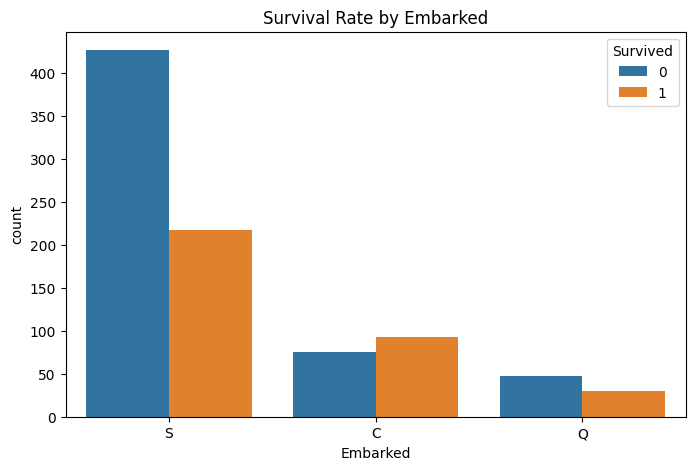

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x='Embarked', hue='Survived', data=df_train)
plt.title('Survival Rate by Embarked')
plt.show()

print(df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

In [11]:
drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
df_train.drop(columns=drop_cols, inplace=True, errors='ignore')
df_test.drop(columns=drop_cols, inplace=True, errors='ignore')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [12]:
num_samples, num_features = df_train.shape
num_features -= 1
num_classes = len(np.unique(df_train['Survived']))
num_samples, num_features, num_classes

(891, 7, 2)

In [13]:
y = df_train['Survived'].values
X = df_train.drop(columns=['Survived'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_val)

(712, 179)

# Preprocessing

In [15]:
X_test = df_test.copy()

print(X_train.isnull().sum())
print(X_val.isnull().sum())

Pclass        0
Sex           0
Age         140
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
Pclass       0
Sex          0
Age         37
SibSp        0
Parch        0
Fare         0
Embarked     0
dtype: int64


In [17]:
X_train.isna().mean() * 100

,0
Pclass,0.000000
Sex,0.000000
Age,19.662921
SibSp,0.000000
Parch,0.000000
Fare,0.000000
Embarked,0.280899


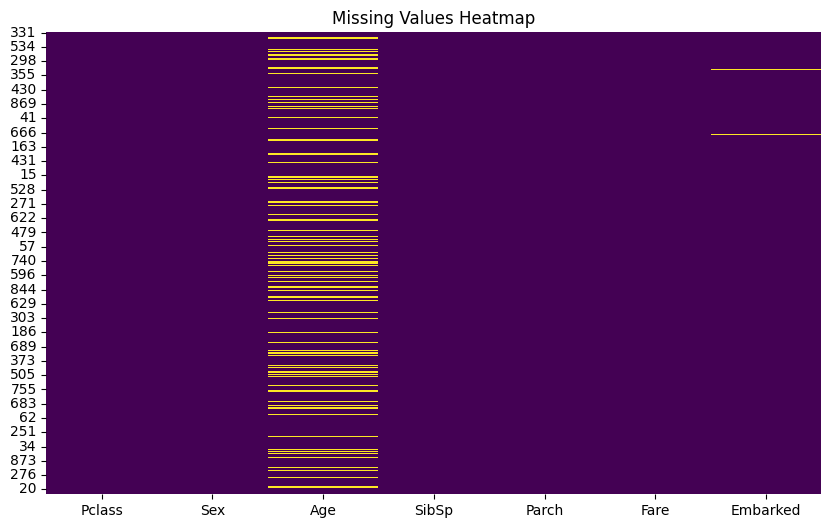

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [20]:
age_mean = X_train['Age'].mean()
embarked_mode = X_train['Embarked'].mode()[0]
age_mean, embarked_mode

(np.float64(29.498846153846156), 'S')

In [21]:
datasets = [X_train, X_val, X_test]

for df in datasets:
    df['Age'] = df['Age'].fillna(age_mean)
    df['Embarked'] = df['Embarked'].fillna(embarked_mode)

In [22]:
X_train.isnull().sum().sum()

np.int64(0)

# Encoding

In [23]:
sex_mapping = {'male': 0, 'female': 1}

for df in datasets:
    df['Sex'] = df['Sex'].map(sex_mapping)

print(X_train[['Sex']].head())

     Sex
331    0
733    0
382    0
704    0
813    1


In [24]:
X_train = pd.get_dummies(X_train, columns=['Embarked'], prefix='Embarked')
X_val = pd.get_dummies(X_val, columns=['Embarked'], prefix='Embarked')
X_test = pd.get_dummies(X_test, columns=['Embarked'], prefix='Embarked')

model_columns = X_train.columns

In [25]:
X_val = X_val.reindex(columns=model_columns, fill_value=0)
X_test = X_test.reindex(columns=model_columns, fill_value=0)

In [26]:
print(X_train.columns.tolist())
X_train.shape, X_val.shape, X_test.shape

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


((712, 9), (179, 9), (418, 9))

# PyTorch

In [28]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [29]:
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,-1.614136,-0.72431,1.232263,-0.470722,-0.479342,-0.078684,-0.461462,-0.303355,0.592489
1,-0.400551,-0.72431,-0.500482,-0.470722,-0.479342,-0.377145,-0.461462,-0.303355,0.592489
2,0.813034,-0.72431,0.192616,-0.470722,-0.479342,-0.474867,-0.461462,-0.303355,0.592489


In [30]:
X_train_arr = X_train.values.astype(np.float32)
X_val_arr = X_val.values.astype(np.float32)
X_test_arr = X_test.values.astype(np.float32)

y_train_arr = y_train.astype(np.float32)
y_val_arr = y_val.astype(np.float32)

In [31]:
X_train_tensor = torch.tensor(X_train_arr)
y_train_tensor = torch.tensor(y_train_arr).unsqueeze(1)

X_val_tensor = torch.tensor(X_val_arr)
y_val_tensor = torch.tensor(y_val_arr).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_arr)

In [32]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [34]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([32, 9]), torch.Size([32, 1]))

# Model

In [ ]:
# class TitanicModel(nn.Module):
#     def __init__(self, input_size):
#         super(TitanicModel, self).__init__()

#         self.layer1 = nn.Linear(input_size, 64)
#         self.act1 = nn.ReLU()
#         self.drop1 = nn.Dropout(0.3)

#         self.layer2 = nn.Linear(64, 32)
#         self.act2 = nn.ReLU()
#         self.drop2 = nn.Dropout(0.3)

#         self.output = nn.Linear(32, 1)

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.act1(x)
#         x = self.drop1(x)

#         x = self.layer2(x)
#         x = self.act2(x)
#         x = self.drop2(x)

#         x = self.output(x)
#         return x

# input_features = X_train.shape[1]

# model = TitanicModel(input_features)

# model = model.to(device)
# print(model)

In [54]:
input_features = X_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_features, 64),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(32, 1)
)
model = model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=9, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=32, out_features=1, bias=True)
)


In [55]:
model[0].weight.shape, model[0].bias.shape

(torch.Size([64, 9]), torch.Size([64]))

# Loss & Optimizer

In [56]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Train

In [57]:
train_losses_hist = []
val_losses_hist = []
train_accs_hist = []
val_accs_hist = []

best_val_loss = float('inf')

In [58]:
EPOCHS = 100

for epoch in range(EPOCHS):

    model.train()

    total_train_loss = 0.0
    correct_train = 0
    total_train_samples = 0

    for inputs, labels in train_loader:
        # GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # zero_grad
        optimizer.zero_grad()
        # model
        outputs = model(inputs)
        # loss
        loss = loss_fn(outputs, labels)
        # gradient
        loss.backward()
        # update
        optimizer.step()

        batch_size = inputs.size(0)
        total_train_loss += loss.item() * batch_size

        predicted = (outputs > 0).float()
        correct_train += (predicted == labels).sum().item()
        total_train_samples += batch_size

    epoch_train_loss = total_train_loss / total_train_samples
    epoch_train_acc = 100 * correct_train / total_train_samples

    model.eval()

    total_val_loss = 0.0
    correct_val = 0
    total_val_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            batch_size = inputs.size(0)
            total_val_loss += loss.item() * batch_size

            predicted = (outputs > 0).float()
            correct_val += (predicted == labels).sum().item()
            total_val_samples += batch_size

    epoch_val_loss = total_val_loss / total_val_samples
    epoch_val_acc = 100 * correct_val / total_val_samples

    train_losses_hist.append(epoch_train_loss)
    val_losses_hist.append(epoch_val_loss)
    train_accs_hist.append(epoch_train_acc)
    val_accs_hist.append(epoch_val_acc)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print(f"💾 Model Saved! (Epoch {epoch+1}) | New Best Val Loss: {best_val_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")

💾 Model Saved! (Epoch 1) | New Best Val Loss: 0.6257
💾 Model Saved! (Epoch 2) | New Best Val Loss: 0.5647
💾 Model Saved! (Epoch 3) | New Best Val Loss: 0.5020
💾 Model Saved! (Epoch 4) | New Best Val Loss: 0.4623
💾 Model Saved! (Epoch 5) | New Best Val Loss: 0.4387
💾 Model Saved! (Epoch 6) | New Best Val Loss: 0.4284
💾 Model Saved! (Epoch 7) | New Best Val Loss: 0.4250
💾 Model Saved! (Epoch 8) | New Best Val Loss: 0.4205
💾 Model Saved! (Epoch 9) | New Best Val Loss: 0.4186
Epoch [10/100] | Train Loss: 0.4445, Acc: 80.20% | Val Loss: 0.4193, Acc: 81.56%
💾 Model Saved! (Epoch 12) | New Best Val Loss: 0.4179
Epoch [20/100] | Train Loss: 0.4094, Acc: 82.58% | Val Loss: 0.4205, Acc: 82.12%
Epoch [30/100] | Train Loss: 0.4151, Acc: 83.01% | Val Loss: 0.4269, Acc: 82.12%
Epoch [40/100] | Train Loss: 0.4039, Acc: 84.13% | Val Loss: 0.4302, Acc: 81.56%
Epoch [50/100] | Train Loss: 0.3989, Acc: 83.99% | Val Loss: 0.4255, Acc: 83.24%
Epoch [60/100] | Train Loss: 0.3904, Acc: 83.71% | Val Loss: 0.4

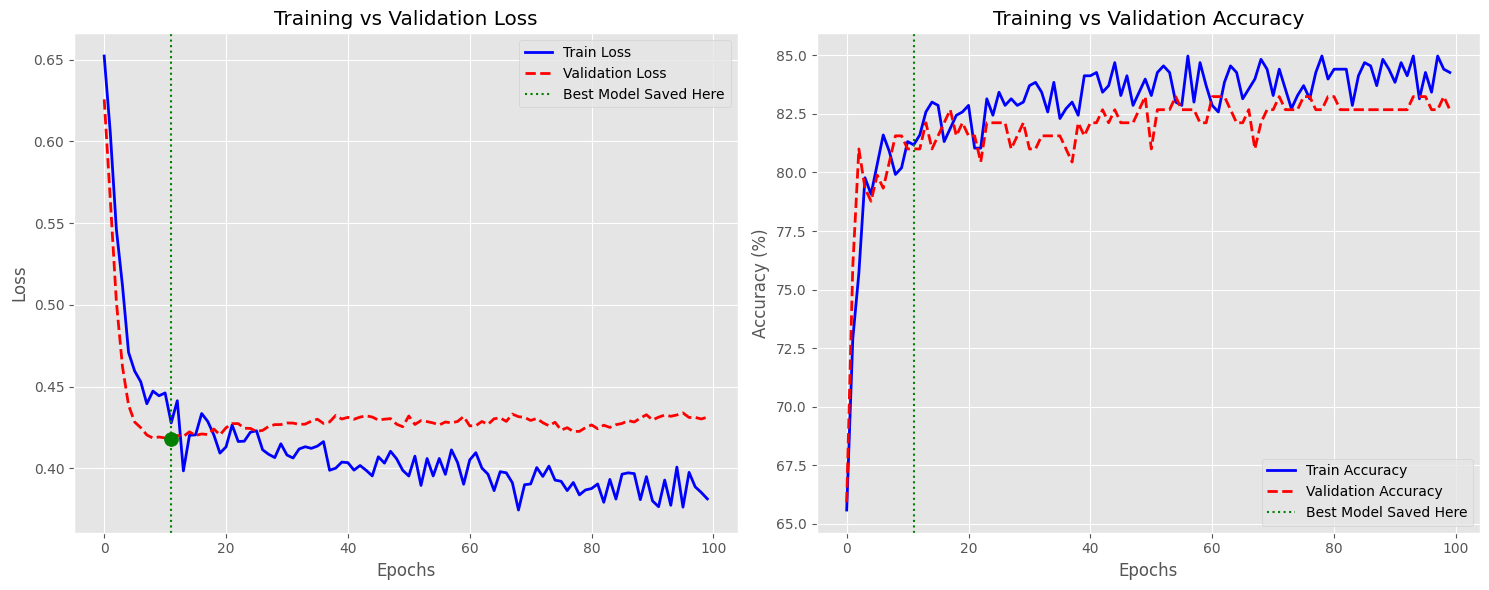

In [59]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(train_losses_hist, label='Train Loss', color='blue', linewidth=2)
ax1.plot(val_losses_hist, label='Validation Loss', color='red', linewidth=2, linestyle='--')

best_epoch = val_losses_hist.index(min(val_losses_hist))
best_loss = min(val_losses_hist)

ax1.axvline(best_epoch, color='green', linestyle=':', label='Best Model Saved Here')
ax1.scatter(best_epoch, best_loss, color='green', s=100, zorder=5)
ax1.set_title('Training vs Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
#############################
ax2.plot(train_accs_hist, label='Train Accuracy', color='blue', linewidth=2)
ax2.plot(val_accs_hist, label='Validation Accuracy', color='red', linewidth=2, linestyle='--')

ax2.axvline(best_epoch, color='green', linestyle=':', label='Best Model Saved Here')
ax2.set_title('Training vs Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()

# Test Submission

In [60]:
model.load_state_dict(torch.load('best_model.pt'))

model.eval()
model.to(device)

Sequential(
  (0): Linear(in_features=9, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=32, out_features=1, bias=True)
)

In [61]:
X_test_tensor = X_test_tensor.to(device)

predictions = []

with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted_labels = (outputs > 0).int().cpu().numpy().flatten()

test_csv_path = 'data/test.csv'
df_test_original = pd.read_csv(test_csv_path)
passenger_ids = df_test_original['PassengerId']

submission_df = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': predicted_labels
})

submission_df.to_csv('submission.csv', index=False)
print(submission_df.head())

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
